In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

## NEED TO SET UP meas_modelfit *before starting ipython* for code at bottom (not included in lsst_apps!)

In [2]:
import diffimTests as dit
reload(dit)

testObj = dit.DiffimTest(varFlux2=np.repeat(5000, 10), 
                         #varFlux2=np.repeat(620*np.sqrt(2), 20),
                         n_sources=600, verbose=True, 
                         sourceFluxRange=(2000., 250000.), saturation=250000., 
                         #bad_columns=[255, 256, 257],
                         variablesAvoidBorder=3.5, psf_yvary_factor=0., psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
Flux range: 249033.759753 2000.0
PSF y spatial-variation: 0.0 0.0
Variable source: 7 452.792255871 412.392281342 0 5000
Variable source: 2 53.7477835412 275.217856552 0 5000
Variable source: 13 453.005019091 297.958858942 0 5000
Variable source: 3 57.4818942906 245.143166623 0 5000
Variable source: 10 73.1909119093 212.227864876 0 5000
Variable source: 14 413.461575292 303.002852121 0 5000
Variable source: 4 107.303982136 258.332221768 0 5000
Variable source: 6 120.376361872 219.968576225 0 5000
Variable source: 9 129.56746846 196.881104362 0 5000
Variable source: 15 391.602266694 234.690863744 0 5000
0 saturated pixels (template)
0 saturated pixels (science)
{'Zogy': {'FP': 0, 'FN': 0, 'TP': 10}, 'ALstack': {'FP': 2, 'FN': 0, 'TP': 10}, 'SZogy': {'FP': 0, 'FN': 0, 'TP': 10}, 'ALstack_decorr': {'FP': 0, 'FN': 0, 'TP': 10}}


In [3]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.pipe.base as pipeBase
import lsst.ip.diffim as ipDiffim

In [4]:
exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

In [5]:
exposure2 = testObj.im2.asAfwExposure()
obj = dit.tasks.PsfMeasurement(exposure2)
obj.run()
psf = obj.exposure.getPsf()
exposure2.setPsf(psf)

template2 = testObj.im1.asAfwExposure()
obj = dit.tasks.PsfMeasurement(template2)
obj.run()
psf = obj.exposure.getPsf()
template2.setPsf(psf)

511
523


In [6]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()

In [17]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

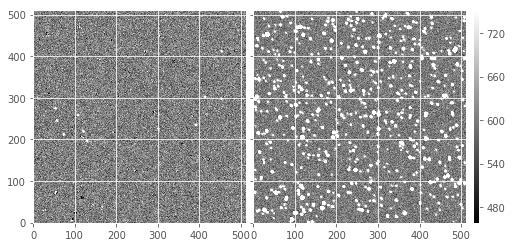

In [8]:
D = task.computeDiffim(inImageSpace=False)
dit.plotImageGrid((D.getMaskedImage().getImage(),
                  D.getMaskedImage().getVariance()), imScale=4)

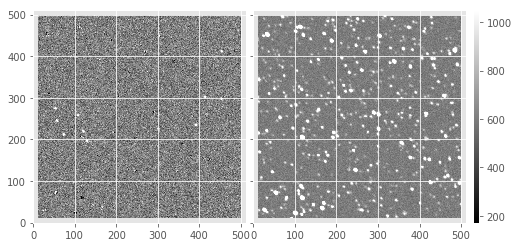

In [13]:
D = task.computeDiffim(inImageSpace=True)
dit.plotImageGrid((D.getMaskedImage().getImage(),
                  D.getMaskedImage().getVariance()), imScale=4)

In [10]:
%timeit task.computeDiffim(inImageSpace=False)

10 loops, best of 3: 112 ms per loop


In [14]:
%timeit task.computeDiffim(inImageSpace=True)

1 loop, best of 3: 559 ms per loop


stats(mean=2.1060252e-10, stdev=4.8384614e-08, min=-4.4403927e-07, max=1.5895642e-06)
stats(mean=4.7857242e-08, stdev=2.4079505e-10, min=4.6926491e-08, max=2.4442909e-07)


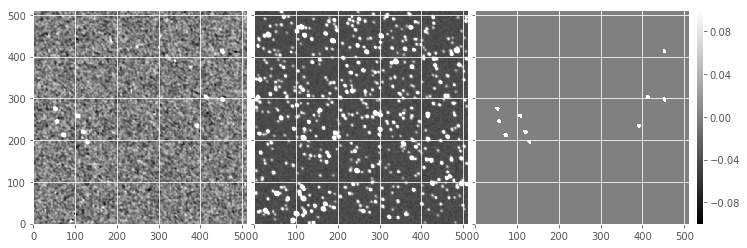

In [36]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

S = task.computeScorr(inImageSpace=False)
print dit.computeClippedImageStats(ga(S))
print dit.computeClippedImageStats(gv(S))
dit.plotImageGrid((ga(S), gv(S), (ga(S)/gv(S) > 5.0)), imScale=4)

stats(mean=2.9694598e-05, stdev=0.0089082113, min=-0.081195429, max=0.29065987)
stats(mean=0.0087511912, stdev=4.4432189e-05, min=0.0085807471, max=0.044695094)


/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


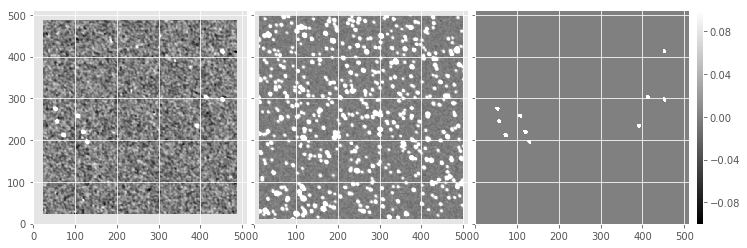

In [37]:
S = task.computeScorr(inImageSpace=True)
print dit.computeClippedImageStats(ga(S))
print dit.computeClippedImageStats(gv(S))
dit.plotImageGrid((ga(S), gv(S), (ga(S)/gv(S) > 5.0)), imScale=4)